In [26]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run, get_parrallel_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
model_name_without_label = "multiple_task_without_label"

# model_name_without_label = "multiple_task_without_label"

task_without_label = "multiple_task_without_label"

run_id = "five_tasks_2"  # if you train more models, replace with the run_id from the table above

run_path_without_label = os.path.join(run_dir, model_name_without_label, run_id)

In [28]:
# model_name_with_label = "multiple_task_with_label_adjust_loss_weight"
model_name_with_label = "multiple_task_with_label"

task_with_label = "multiple_task_with_label"

run_id = "five_tasks"  # if you train more models, replace with the run_id from the table above

run_path_with_label = os.path.join(run_dir, model_name_with_label, run_id)

In [29]:
model_name_without_label_cat_loss = "multiple_task_without_label_cat_loss"
# model_name_with_label = "multiple_task_with_label"

task_without_label_cat_loss = "mmultiple_task_without_label_cat_loss"

run_id = "five_tasks_2"  # if you train more models, replace with the run_id from the table above

run_path_without_label_cat_loss = os.path.join(run_dir, model_name_without_label_cat_loss, run_id)

# Plot pre-computed metrics

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [31]:
from samplers import get_data_sampler
from tasks import get_task_sampler

dwwwddddddd

In [52]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [53]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [54]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [55]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 0,)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [56]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 0, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_with_label(pred_without_label_cat_loss[0], ys).cpu().numpy()

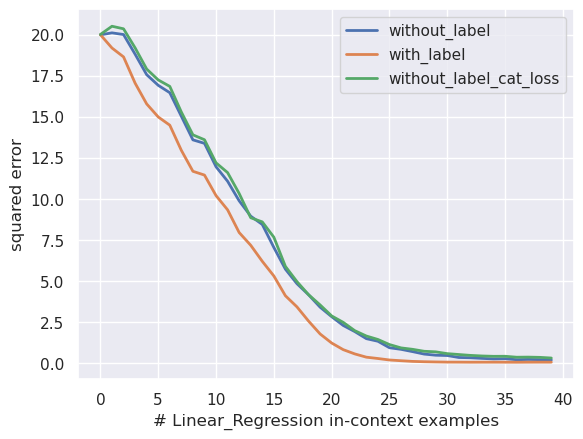

In [60]:
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# Linear_Regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [88]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 10

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "quadratic_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [89]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [90]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [85]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 1)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [91]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 1, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_with_label(pred_without_label_cat_loss[0], ys).cpu().numpy()

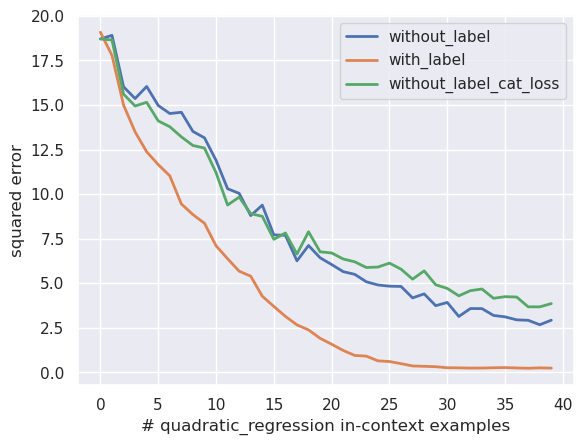

In [93]:
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# quadratic_regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [94]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "cube_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [95]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [96]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [97]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 2)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [98]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 2, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_with_label(pred_without_label_cat_loss[0], ys).cpu().numpy()

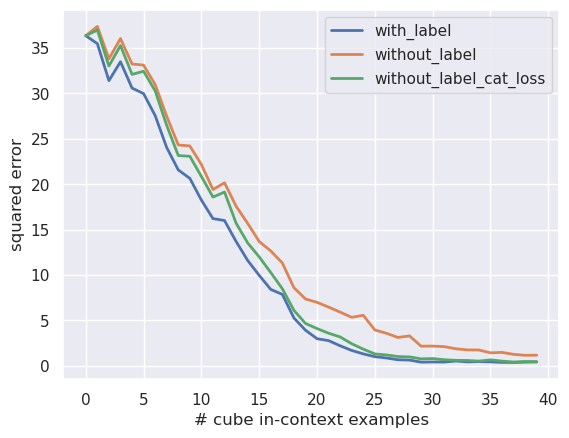

In [100]:

plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label_cat_loss")
plt.xlabel("# cube in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [113]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "relu_2nn_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [114]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [115]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [119]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 3)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [117]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 3, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_with_label(pred_without_label_cat_loss[0], ys).cpu().numpy()

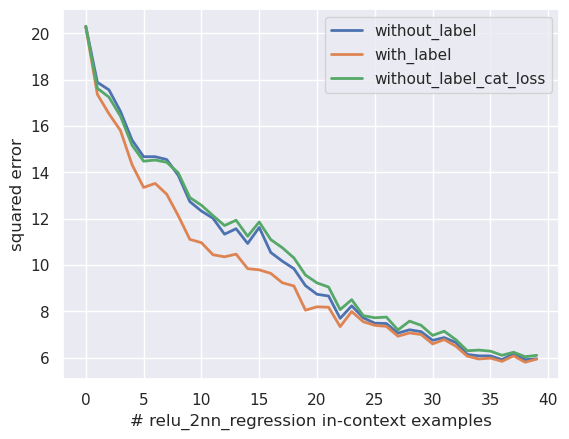

In [120]:
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# relu_2nn_regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [107]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "decision_tree",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [108]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [109]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [110]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 4)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [111]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 4, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_with_label(pred_without_label_cat_loss[0], ys).cpu().numpy()

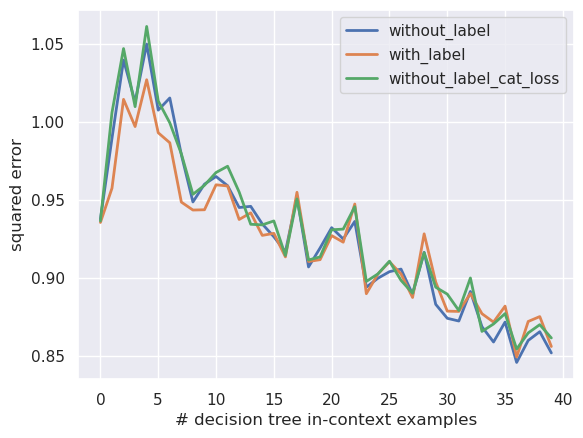

In [112]:
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# decision tree in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()